In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units

# import personal modules
sys.path.append('../modules') # Path to modules
from preprocess_dataframes import combine_ivt_ar_prec_df
import nclcmaps as nclc
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
# Set up paths

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_work = '/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/SEAK-WRF-PCPT/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go
ext1 = [-141., -130., 54., 61.] # extent of SEAK

# list of extents for each community
dx = 1.5
dy = 1.5
ext_lst = []
for x,y in zip(xs,ys):
    ext_lst.append([x-dx, x+dx, y-dy, y+dy])

ext_lst

[[-136.9519, -133.9519, 56.6122, 59.6122],
 [-136.8277, -133.8277, 57.9538, 60.9538],
 [-137.3894, -134.3894, 57.8988, 60.8988],
 [-141.171, -138.171, 58.0121, 61.0121],
 [-134.6358, -131.6358, 53.9769, 56.9769],
 [-133.9009, -130.9009, 54.04, 57.04]]

In [4]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

df_lst = combine_ivt_ar_prec_df(option, temporal_res, community_lst) # combine dfs into list of dfs
df_lst[0]

,time,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir,AR,impact,prec
time,,,,,,,,,,,
1980-01-01,1980-01-01,77.66,58.00,-135.50,0.49,75.10,10.93,184.72,0,0,6.35
1980-01-02,1980-01-02,100.72,58.00,-135.50,-28.84,93.67,11.23,161.07,0,0,10.58
1980-01-03,1980-01-03,62.80,58.00,-135.50,6.30,59.67,9.13,193.02,0,0,20.42
1980-01-04,1980-01-04,19.53,58.00,-135.50,5.74,-16.81,3.08,337.15,0,0,0.19
1980-01-05,1980-01-05,102.21,58.00,-135.50,70.40,-67.56,5.18,323.07,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019-12-27,91.43,58.00,-135.50,61.35,65.65,7.73,225.77,0,1,1.05
2019-12-28,2019-12-28,221.96,58.00,-135.50,39.06,209.42,12.02,199.91,0,0,15.38
2019-12-29,2019-12-29,89.09,58.00,-135.50,13.36,85.46,9.03,188.47,0,0,NaN


In [5]:
## get list of dates that are Extreme Precip and AR for each community
ardate_lst = []
for i, df in enumerate(df_lst):
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    # idx = (df.AR == 1) & (df.prec > prec_thres) 
    idx = (df.AR == 1) & (df.prec > prec_thres) & (df.index != '2008-02-29 00:00:00') # hack to get rid of the leap day (not in WRF data)
    tmp = df.loc[idx]
    
    ar_dates = tmp.time.values
    ardate_lst.append(tmp.time.values)

## Load Precipitation Data

In [6]:
fname_pattern = path_to_work + 'WRFDS_PCPT_*.nc'
wrf = xr.open_mfdataset(fname_pattern, combine='by_coords')
if temporal_res == 'hourly':
    wrf = wrf
elif temporal_res == 'daily':
    wrf = wrf.resample(time="1D").sum('time') # resample WRF data to be mm per day
wrf

<xarray.Dataset>
Dimensions:  (time: 14610, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(250, 320), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    PCPT     (time, y, x) float32 dask.array<chunksize=(1, 250, 320), meta=np.ndarray>
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Sat Dec  8 15:40:16 AKST 2018

In [7]:
## Having trouble with wrf ds not having all the dates in the ar_dates list 
## use this to find out which dates are having a problem
# make a pandas dataframe of AR Dates
answer_lst = []
for i, ar_dates in enumerate(ardate_lst):
    d = {'dates': ar_dates}
    df_A = pd.DataFrame(data=d)
    df_A = df_A.set_index(pd.to_datetime(df_A['dates'])) # reset the index as "dates"


    # make a pandas dataframe of WRF dates
    d = {'dates': wrf.time}
    df_B = pd.DataFrame(data=d)
    df_B = df_B.set_index(pd.to_datetime(df_B['dates'])) # reset the index as "dates"

    # test = df_A.isin(df_B)

    x = df_A.index
    y = df_B.index
    test = x.isin(y)

    idx = (test== False)
    answer = df_A.loc[idx]
    answer_lst.append(answer.dates.values)
answer_lst

[array([], dtype='datetime64[ns]'),
 array([], dtype='datetime64[ns]'),
 array([], dtype='datetime64[ns]'),
 array([], dtype='datetime64[ns]'),
 array([], dtype='datetime64[ns]'),
 array([], dtype='datetime64[ns]')]

In [8]:
%%time
## make a dataset for each community subset to its AR dates
ds_lst = []
for i, ar_dates in enumerate(ardate_lst):
    print('Processing {0}'.format(community_lst[i]))
    tmp = wrf.sel(time=ar_dates)
    tmp = tmp.mean('time')
    ds_lst.append(tmp.load())
    
ds_lst[0]

Processing Hoonah
Processing Skagway
Processing Klukwan
Processing Yakutat
Processing Craig
Processing Kasaan
CPU times: user 52.3 s, sys: 10min 41s, total: 11min 34s
Wall time: 38min 18s


<xarray.Dataset>
Dimensions:  (y: 250, x: 320)
Coordinates:
    lat      (y, x) float32 53.12 53.12 53.13 53.13 ... 61.97 61.97 61.96 61.95
    lon      (y, x) float32 -148.1 -148.0 -147.9 -147.9 ... -126.4 -126.3 -126.3
Dimensions without coordinates: y, x
Data variables:
    PCPT     (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [9]:
## merge all communities into single DS with "community name" as axis
prec_comp = xr.concat(ds_lst, dim=community_lst)
## calculate average of all 6 communities
prec_mean = prec_comp.mean('concat_dim')

## subtract the mean from the original composites
prec_diff = prec_comp - prec_mean

### Load elevation data

In [16]:
## Open southwest_geo.nc to pull projection information
wrf_elev = xr.open_dataset(path_to_data + 'downloads/geo_southeast.nc')
wrf_elev = wrf_elev.isel(Time=0)
elev = wrf_elev.HGT_M.values
wrflats = wrf_elev.CLAT.values
wrflons = wrf_elev.CLONG.values

## Plot Precitation Composites

In [11]:
# Set up projection
mapcrs = ccrs.Mercator()
# mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = wrf.lat.values[:, 0]
lons = wrf.lon.values[0, :]
dx = np.arange(lons.min().round(),lons.max().round()+1,1)
dy = np.arange(lats.min().round(),lats.max().round()+1,1)

ext1 = [-141., -130., 54., 61.] # extent of SEAK

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

/tmp/ipykernel_27055/3566279146.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(nrows, ncols, k+1, projection=mapcrs)


103.77926
155.81497
156.40555
123.3881
91.381096
71.099174


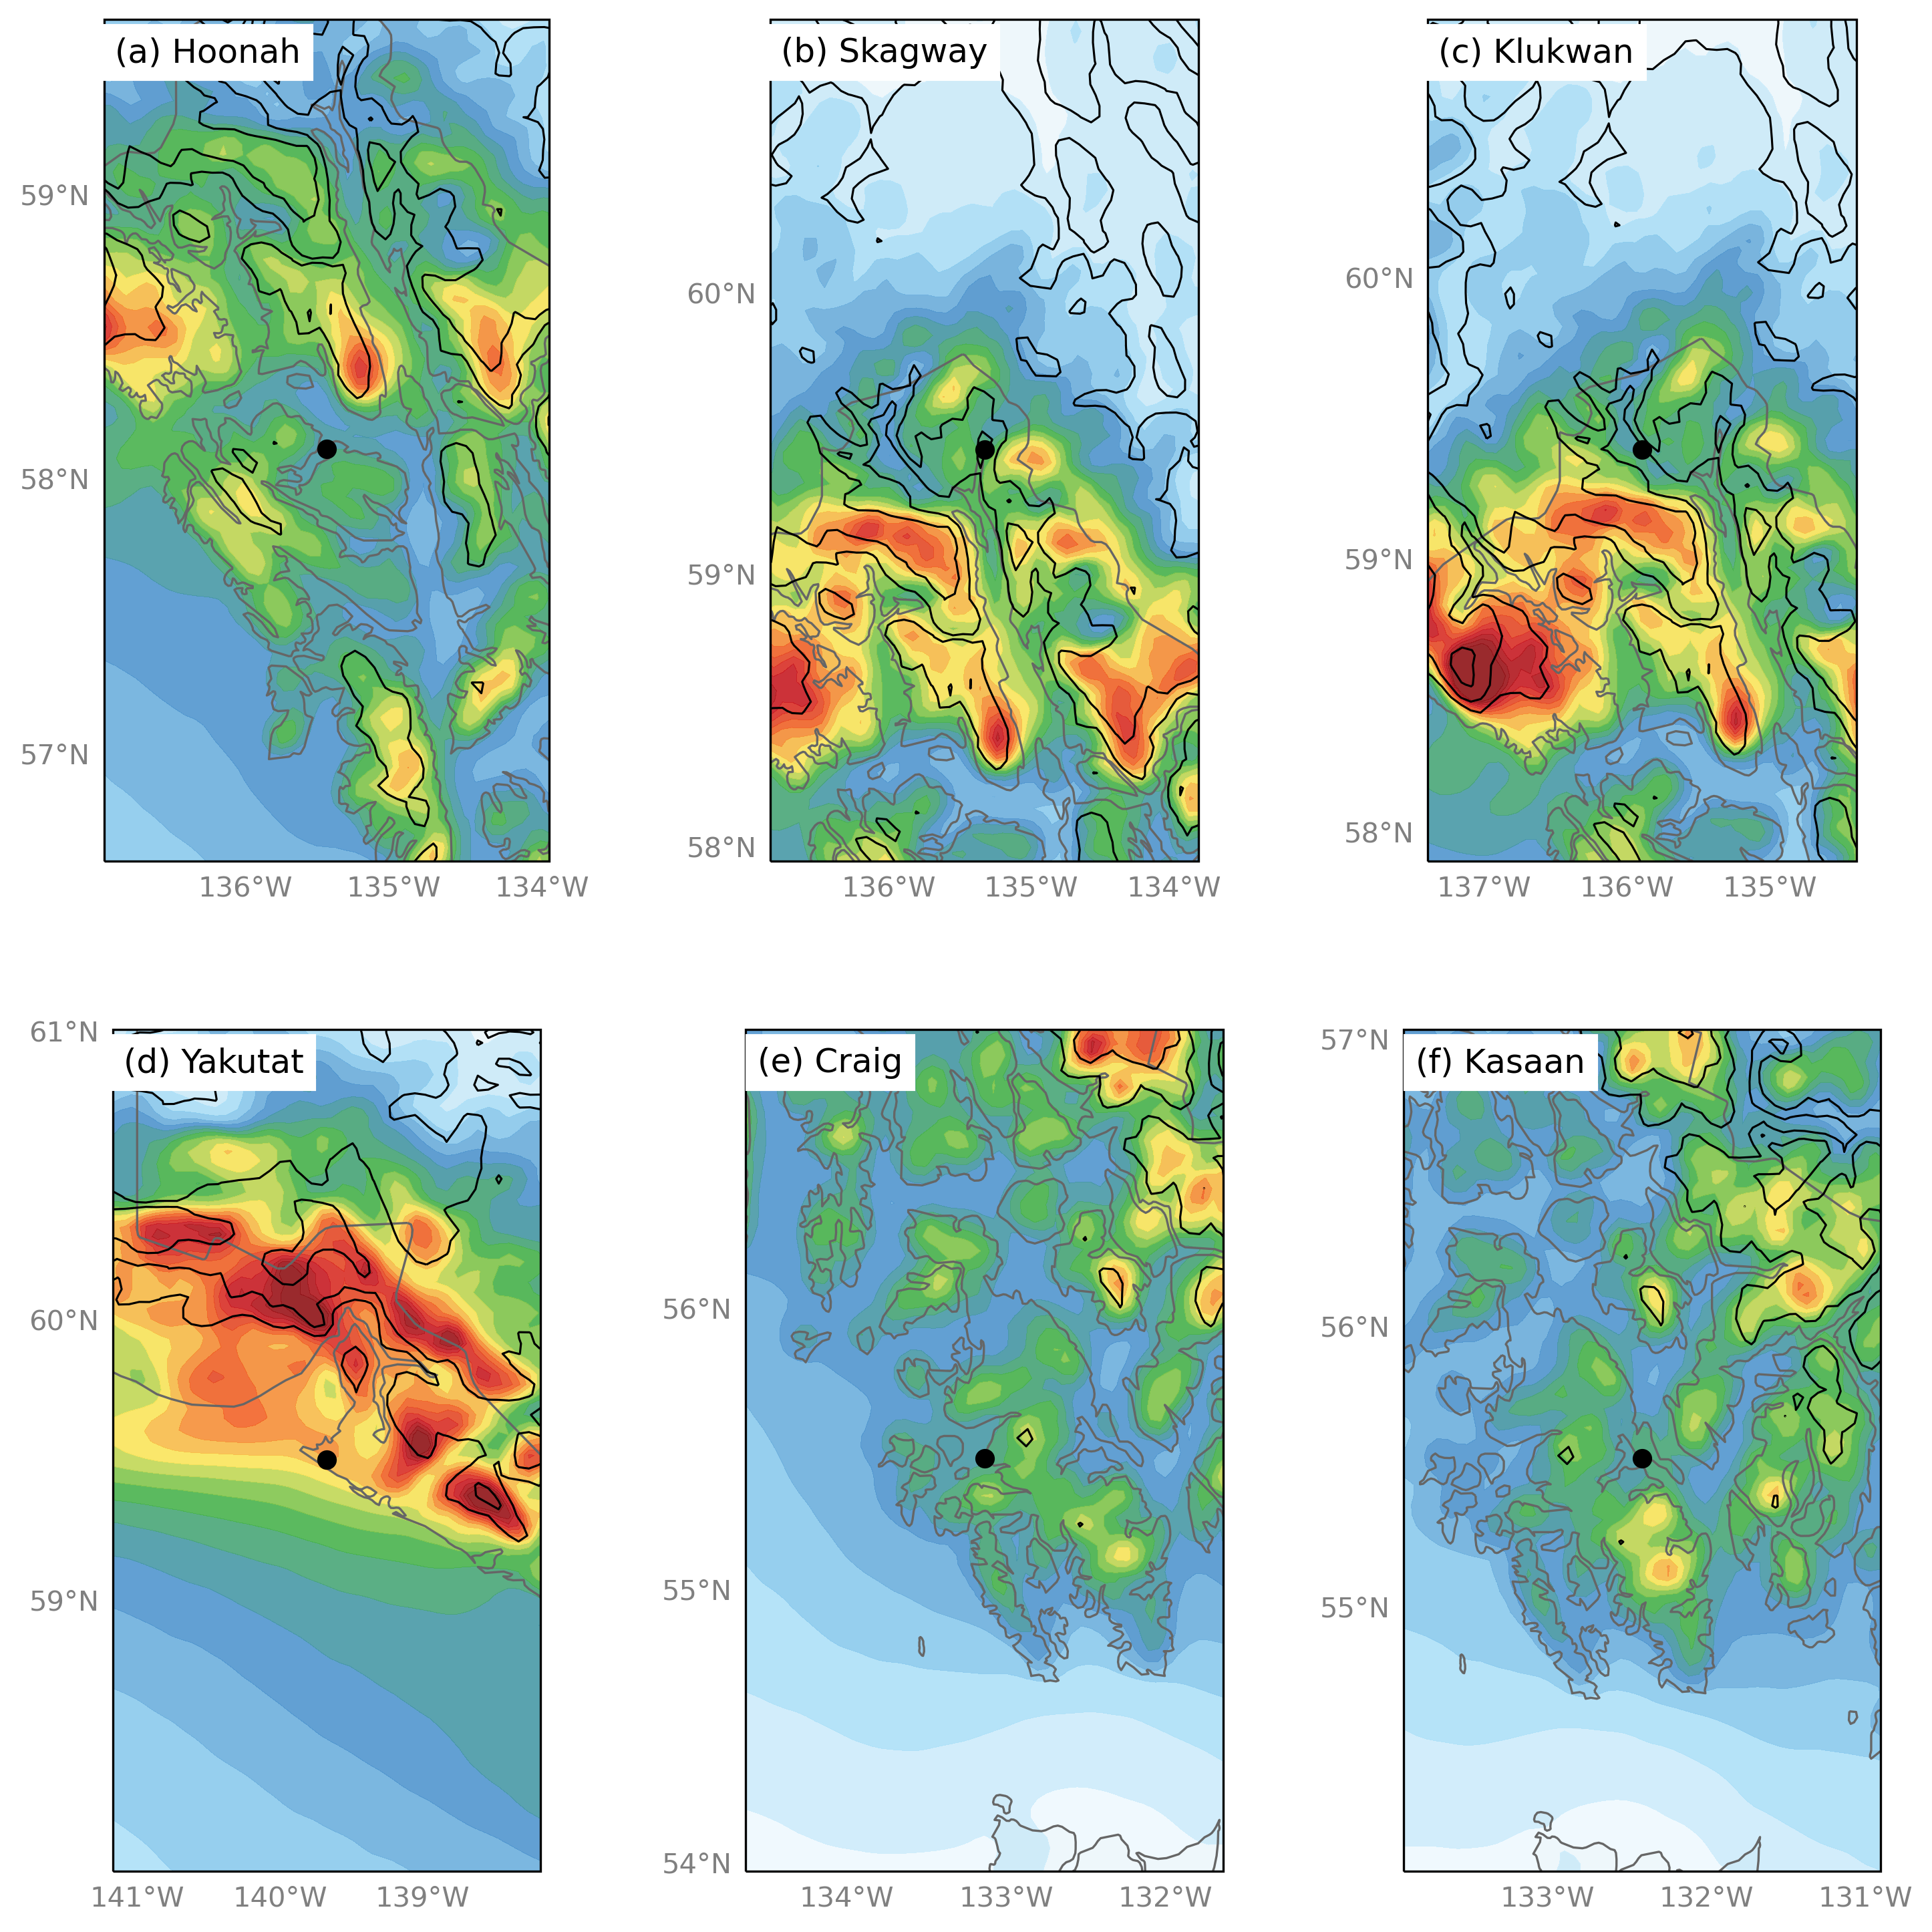

In [19]:
left_lat_lst = [True, False, False, True, False, False]
bottom_lon_lst = [False, False, False, True, True, True]
# Create figure
fig = plt.figure(figsize=(12, 12))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_prec_composite_all_{0}'.format(temporal_res)
fmt = 'png'

nrows = 2
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.3,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='3%',label_mode='')

# for k, ax in enumerate(axgr):
for k in np.arange(nrows*ncols):
    ax = plt.subplot(nrows, ncols, k+1, projection=mapcrs)
    ds = prec_comp.sel(concat_dim=community_lst[k])
    ax = draw_basemap(ax, extent=ext_lst[k], xticks=dx, yticks=dy,left_lats=True, right_lats=False, bottom_lons=True)

    # Contour Filled
    prec = ds.PCPT.values
    print(np.nanmax(prec))
    if temporal_res == 'hourly':
        clevs = np.arange(0.1, 2.2, 0.1)
        clabel = 'precipitation (mm hour$^{-1}$)'
    elif temporal_res == 'daily':
        clevs = np.arange(0.0, 105, 5)
        clabel = 'precipitation (mm day$^{-1}$)'
    cf = ax.contourf(ds.lon.values, ds.lat.values, prec, transform=datacrs,
                     levels=clevs, cmap=nclc.cmap('WhiteBlueGreenYellowRed'), alpha=0.9, extend='max')
    
    # elevation contour
    clevs=np.array([500, 1000, 2000])
    cs = ax.contour(wrflons, wrflats, elev, clevs, colors='k', linewidths=0.75,
                    linestyles='solid', transform=datacrs)

    titlestring = '({0}) {1}'.format(letter_lst[k], community_lst[k])
    ax.text(0.025, 0.98, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)

    # Plot Location of community pts
    ax.plot(xs[k], ys[k], 'ko', markersize=6, transform=datacrs)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label(clabel, fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

In [ ]:
# Create figure
fig = plt.figure(figsize=(8, 12))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_prec_composite_{0}_summary'.format(temporal_res)
fmt = 'png'

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')


for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, mask_ocean=False)

    # Contour Filled
    ds = prec_mean
    print(np.nanmax(prec))
    if temporal_res == 'hourly':
        clevs = np.arange(0.1, 2.2, 0.1)
        clabel = 'precipitation (mm hour$^{-1}$)'
    elif temporal_res == 'daily':
        clevs = np.arange(0.1, 165, 15)
        clabel = 'precipitation (mm day$^{-1}$)'
    cf = ax.contourf(ds.lon.values, ds.lat.values, ds.PCPT.values, transform=datacrs,
                     levels=clevs, cmap=nclc.cmap('WhiteBlueGreenYellowRed'), alpha=0.9, extend='max')
    
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)
    
    ## Plot the locations of the focus communities
    # zip joins x and y coordinates in pairs
    for x,y,z,ha in zip(xs,ys, lbl1, lbl_align):

        # Plot Location of pts
        ax.plot(x, y, 'ro', markersize=6, transform=datacrs)

        ax.annotate(z, # this is the text
                   (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,12), # distance from text to points (x,y)
                    ha=ha, # horizontal alignment can be left, right or center
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=0.5, alpha=0.8),
                    xycoords=transform,
                    zorder=102,
                    fontsize=14)



# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label(clabel, fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()